# Data loading and preprocessing

In [4]:
# Requirements:
!pip install pandas numpy seaborn matplotlib scikit-learn

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from scipy import stats
from scipy.stats import kstest
from scipy.stats import linregress

Let's set the seed so that the results are reproducible.

In [6]:
seed = 123
np.random.seed(seed)

Now, we will load the data into a pandas DataFrame.

In [7]:
df = pd.read_csv('electronic_company_data.csv')
df = df.rename(columns={"impedence": "impedance", "impedence_fluctuation": "impedance_fluctuation"})
df.head()

,impedance,impedance_fluctuation,applied_voltage,output_current,configured_resistance,saturated,max_force_applicable,quality_index,connector_type,broke
0,2.018773,1.119372,-27.0,2.784376,11,False,3.018773,4.489199,type_b,1
1,1.286763,0.986367,17.0,9.323103,26,False,3.286763,1.923110,type_a,1
2,-1.430952,-0.228286,9.0,2.319531,78,False,-1.430952,1.771434,type_b,1
3,-0.081414,0.135956,7.0,0.898874,19,False,-0.081414,0.000345,type_b,1
4,-2.412152,0.183943,18.0,3.093290,99,False,-2.412152,5.346047,type_b,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   impedance              9999 non-null   float64
 1   impedance_fluctuation  9999 non-null   float64
 2   applied_voltage        9998 non-null   float64
 3   output_current         9993 non-null   float64
 4   configured_resistance  9999 non-null   int64  
 5   saturated              9999 non-null   bool   
 6   max_force_applicable   9999 non-null   float64
 7   quality_index          9999 non-null   float64
 8   connector_type         9999 non-null   object 
 9   broke                  9999 non-null   int64  
dtypes: bool(1), float64(6), int64(2), object(1)
memory usage: 712.9+ KB


We have 9999 rows, i.e., electronic components, with 10 columns (attributes) each. Let us now check if there are null values.

In [9]:
df.isnull().sum()

impedance                0
impedance_fluctuation    0
applied_voltage          1
output_current           6
configured_resistance    0
saturated                0
max_force_applicable     0
quality_index            0
connector_type           0
broke                    0
dtype: int64

We have decided to impute the missing entries with the most common value (mean/mode, depending on whether the attribute is numerical or categorical), since it has been shown to give better classification results in Weka. Another reason is that the dataset is not too big, so we prefer not to reduce the size even more by removing entries with missing values (although in this case it would not be a big problem because of the low proportion of missing entries).

In [10]:
# Since both applied_voltage and output_current are numerical variables, we will impute with the mean
df['applied_voltage'].fillna(df['applied_voltage'].mean(), inplace=True)
df['output_current'].fillna(df['output_current'].mean(), inplace=True)
df.isnull().sum()

impedance                0
impedance_fluctuation    0
applied_voltage          0
output_current           0
configured_resistance    0
saturated                0
max_force_applicable     0
quality_index            0
connector_type           0
broke                    0
dtype: int64

There are two attributes that have been loaded with a wrong type: *applied_voltage* should be of the integer type, and *broke*, the class, should be binary. However, we will actually leave the *broke* column type as integer, and instead chang *saturated* also into integer, so that it is easier to work with it.

In [11]:
df["applied_voltage"] = df["applied_voltage"].astype(int)
df["saturated"] = df["saturated"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   impedance              9999 non-null   float64
 1   impedance_fluctuation  9999 non-null   float64
 2   applied_voltage        9999 non-null   int32  
 3   output_current         9999 non-null   float64
 4   configured_resistance  9999 non-null   int64  
 5   saturated              9999 non-null   int32  
 6   max_force_applicable   9999 non-null   float64
 7   quality_index          9999 non-null   float64
 8   connector_type         9999 non-null   object 
 9   broke                  9999 non-null   int64  
dtypes: float64(5), int32(2), int64(2), object(1)
memory usage: 703.2+ KB


We now have 9992 entries to work with. Let us see an statistical description of the dataset.

In [12]:
df.describe()

,impedance,impedance_fluctuation,applied_voltage,output_current,configured_resistance,saturated,max_force_applicable,quality_index,broke
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9.999000e+03,9999.000000
mean,-0.008784,0.499905,7.065007,-0.138724,49.845585,0.062006,0.580775,1.004688e+00,0.502050
std,0.993014,0.352210,9.850136,83.630052,28.814403,0.241179,1.405583,1.416555e+00,0.500021
min,-4.122472,-0.616887,-30.000000,-5897.951767,0.000000,0.000000,-3.621729,2.930108e-08,0.000000
25%,-0.675804,0.240536,3.000000,-1.433127,25.000000,0.000000,-0.359535,1.094331e-01,0.000000
50%,-0.005021,0.499282,8.000000,-0.201704,49.000000,0.000000,0.450385,4.599752e-01,1.000000
75%,0.658960,0.762734,14.000000,1.048114,75.000000,0.000000,1.362258,1.323922e+00,1.000000
max,3.649320,1.680663,19.000000,2603.293146,105.000000,1.000000,9.861365,1.618028e+01,1.000000


Since *connector_type* is a categorical attribute, we want to check what are its possible values and their distribution.

In [13]:
print(df["connector_type"].unique())
print()    # new line

def categorical_counts(col):
    print("Number of values per category:")
    print(df[col].value_counts())                
    print("\nFraction of values per category:")
    print(df[col].value_counts(normalize=True))  

categorical_counts("connector_type")

['type_b' 'type_a' 'other']

Number of values per category:
connector_type
type_b    5066
type_a    4928
other        5
Name: count, dtype: int64

Fraction of values per category:
connector_type
type_b    0.506651
type_a    0.492849
other     0.000500
Name: proportion, dtype: float64


And we can do the same for the *saturated* and *broke* variables:

In [14]:
categorical_counts("saturated")

Number of values per category:
saturated
0    9379
1     620
Name: count, dtype: int64

Fraction of values per category:
saturated
0    0.937994
1    0.062006
Name: proportion, dtype: float64


In [15]:
categorical_counts("broke")

Number of values per category:
broke
1    5020
0    4979
Name: count, dtype: int64

Fraction of values per category:
broke
1    0.50205
0    0.49795
Name: proportion, dtype: float64


In [16]:
d = df.duplicated().sum()     # Are there any duplicated rows?
if d:
    print("There are {} duplicated rows.".format(d))
else:
    print("There are no duplicated rows.")

There are no duplicated rows.


## Visualizations

We will now print a histogram for each numerical column.

In [17]:
def plot_histogram(data, title, xlabel, ylabel, bins=10, weights=None, yscale='linear'):
    "Plot a histogram customizing it with the arguments and using a gradient color scheme to reflect the frequency of the values"
    # The color of the edges of the rectangles is grey
    n, bins, patches = plt.hist(data, bins=bins, linewidth=0.5, edgecolor = 'black', weights=weights)
    
    # Turn n into an integer
    n = n.astype('int')
    
    # Color the patches, each of which represents a single bin, with a gradient
    for i in range(len(patches)):
        patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
        
    plt.yscale(yscale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=12)
    plt.grid(True)
    plt.show()
    

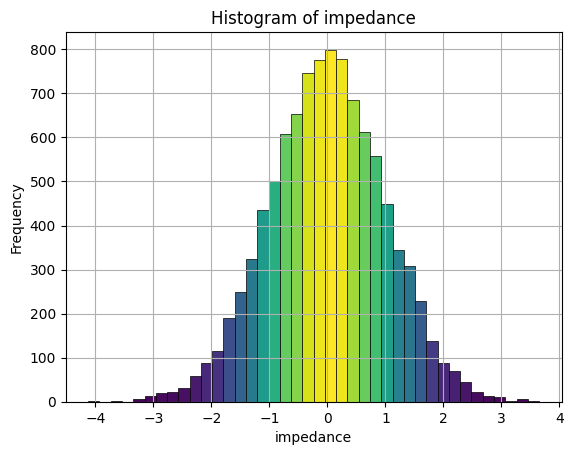

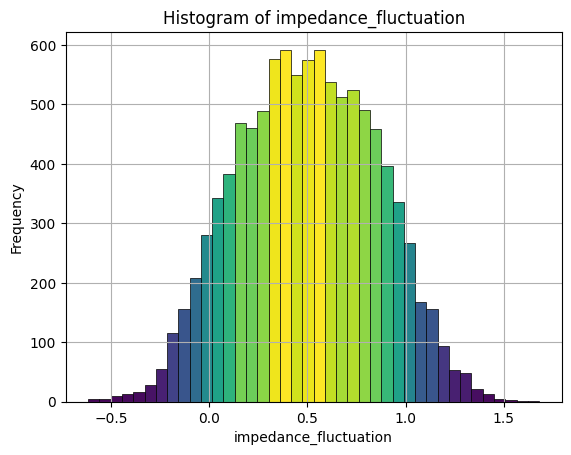

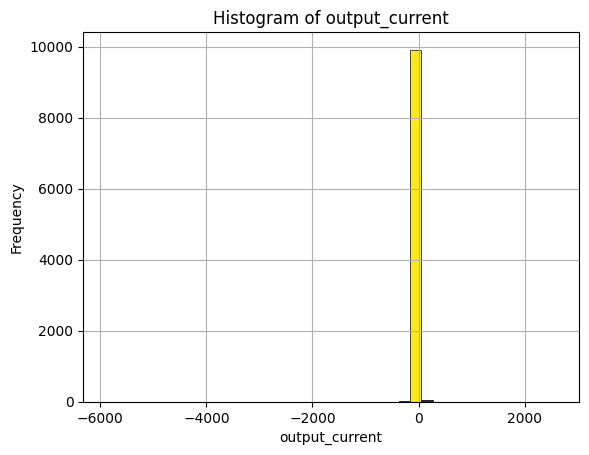

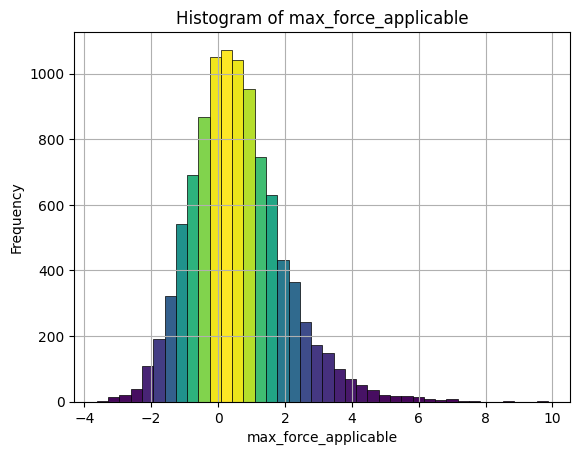

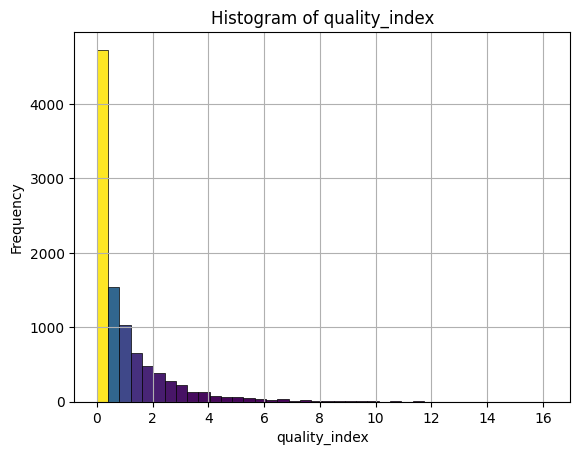

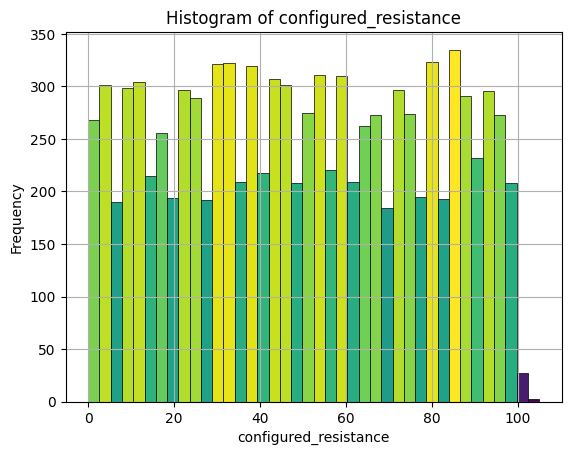

In [18]:
numerical_df = df.select_dtypes(include=['float'])
numerical_df["configured_resistance"] = df["configured_resistance"]

for col in numerical_df.columns:
    plot_histogram(numerical_df[col], title="Histogram of " + col, xlabel=col, ylabel="Frequency", bins=40)

For the categorical columns, we will instead use bar plots and pie charts.

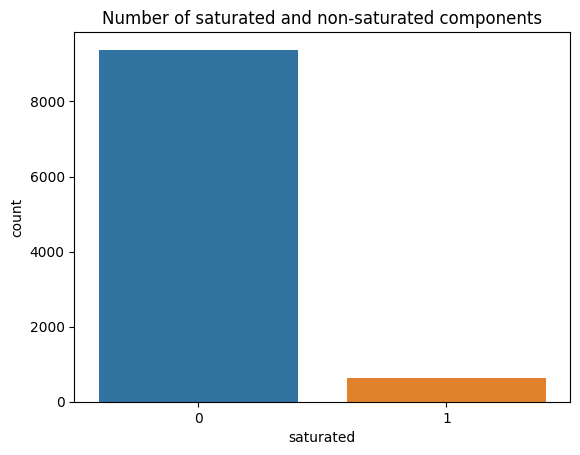

In [19]:
sns.countplot(x='saturated', data=df)
plt.title("Number of saturated and non-saturated components")
plt.show()

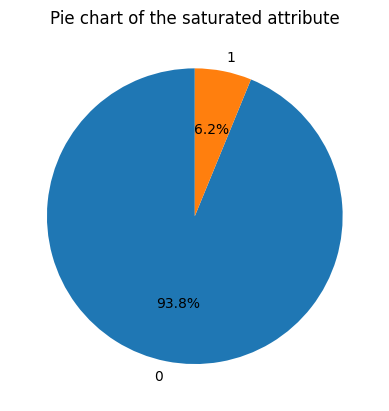

In [20]:
plt.pie(df["saturated"].value_counts(), labels=["0", "1"], autopct='%1.1f%%', startangle=90)
plt.title("Pie chart of the saturated attribute")
plt.show()

Almost all of the components are non saturated.

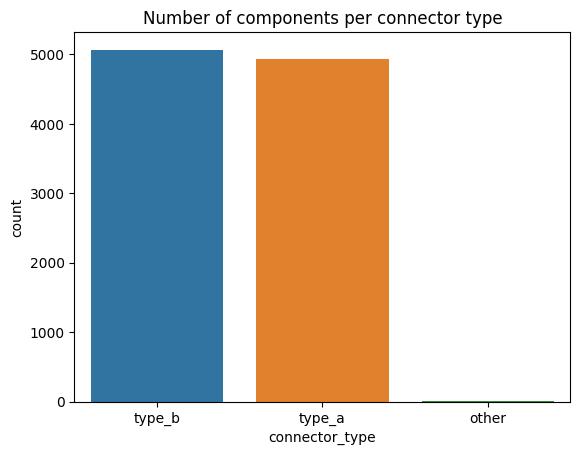

In [21]:
sns.countplot(x='connector_type', data=df)
plt.title("Number of components per connector type")
plt.show()

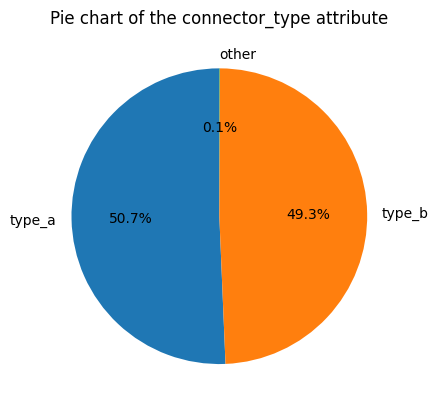

In [22]:
plt.pie(df["connector_type"].value_counts(), labels=["type_a", "type_b", "other"], autopct='%1.1f%%', startangle=90)
plt.title("Pie chart of the connector_type attribute")
plt.show()

There are very few components of the "other" type. The rest are distributed between "type_a" and "type_b" almost evenly.

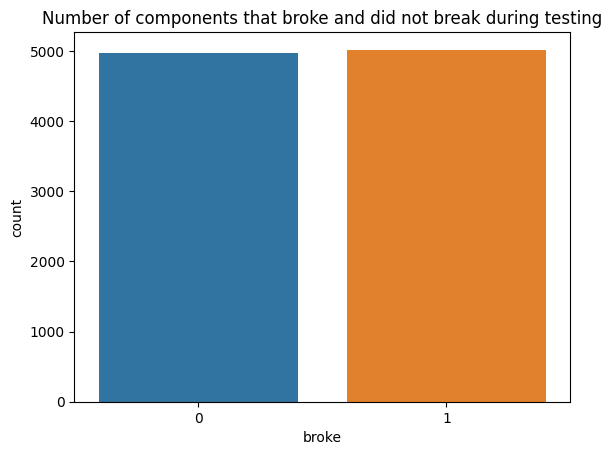

In [23]:
sns.countplot(x='broke', data=df)
plt.title("Number of components that broke and did not break during testing")
plt.show()

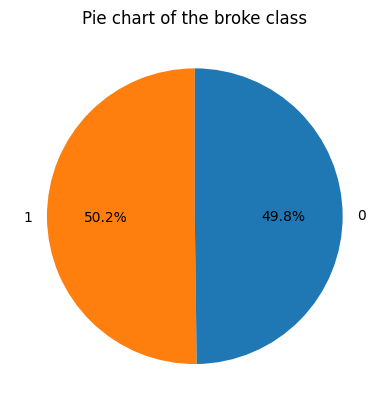

In [24]:
# We can change the colors of the pie chart to match the colors of the bar chart
plt.pie(df["broke"].value_counts(), labels=["1", "0"], colors=["tab:orange", "tab:blue"], autopct='%1.1f%%', startangle=90)
plt.title("Pie chart of the broke class")
plt.show()

The class, *broke*, is almost perfectly equally distributed.

We can also generate boxplots for the numerical columns.

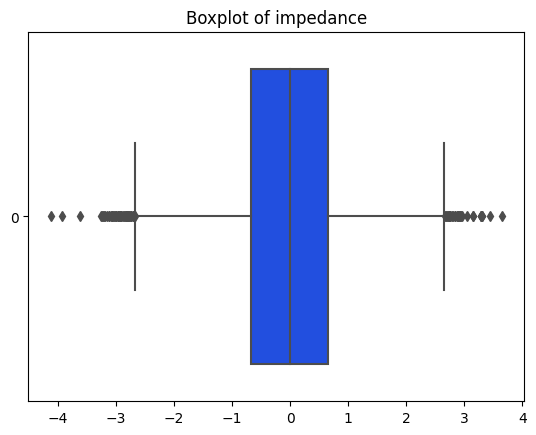

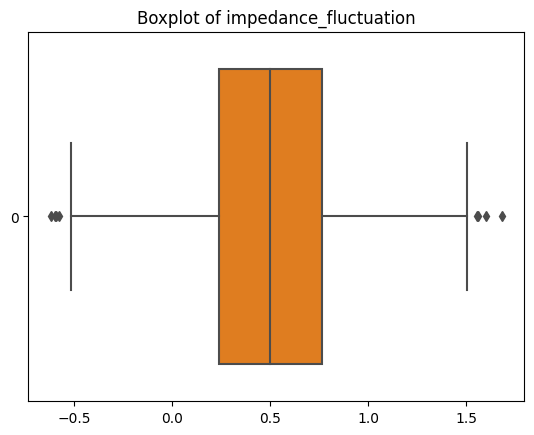

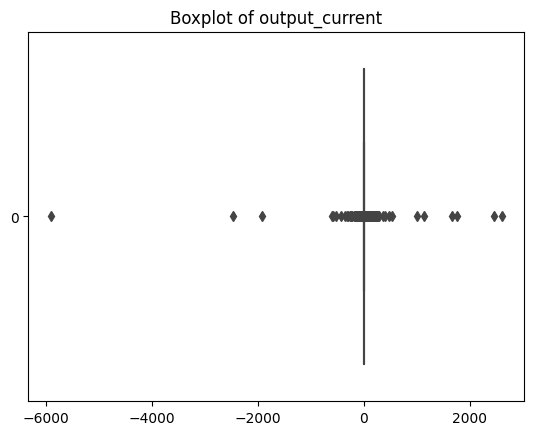

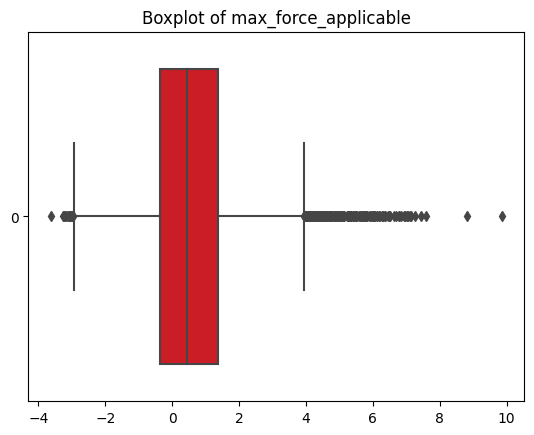

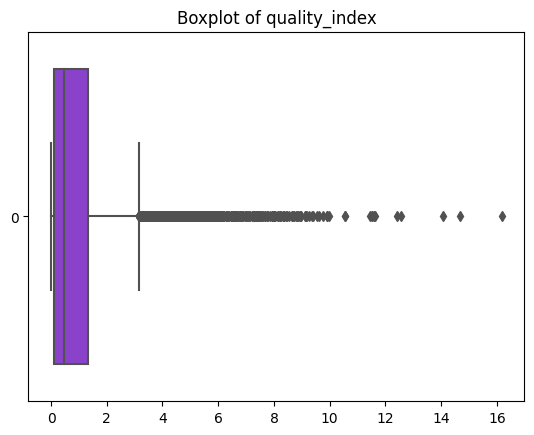

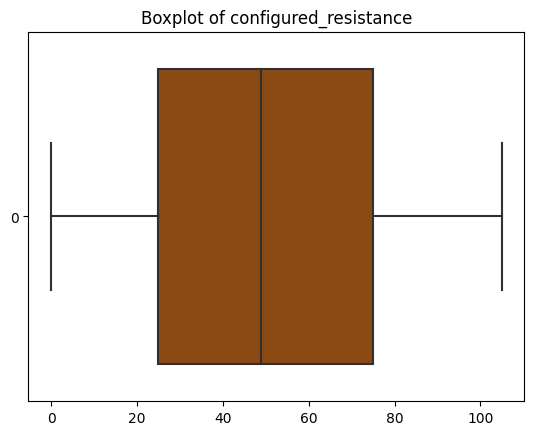

In [25]:
colors = sns.color_palette('bright', len(numerical_df.columns))   
for i, col in enumerate(numerical_df.columns):
    sns.boxplot(data=df[col], color=colors[i], orient="h")
    plt.title("Boxplot of {}".format(col))
    plt.show()

## Attribute tuning

We will substitute the categorical variable *connector_type* with 3 binary variables, one for each type, so that we can manipulate the data more easily.

In [26]:
# Transform categorical variables into numerical variables
df = pd.get_dummies(df, columns=['connector_type'])
df.columns

Index(['impedance', 'impedance_fluctuation', 'applied_voltage',
       'output_current', 'configured_resistance', 'saturated',
       'max_force_applicable', 'quality_index', 'broke',
       'connector_type_other', 'connector_type_type_a',
       'connector_type_type_b'],
      dtype='object')

Let us now see if we can transform *output_current* to obtain more meaningful insights from it.

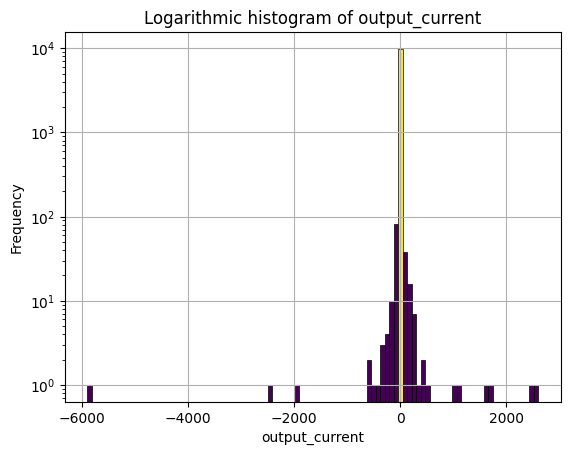

In [27]:
plot_histogram(df["output_current"], title="Logarithmic histogram of output_current", xlabel="output_current", ylabel="Frequency", bins=100, yscale='log')

As we can see when we plot a histogram with a logarithmic distribution, there are very few outliers, but they are very extreme. This could indicate that their presence is just due to an error in the measurements or to faulty components. Let us examine them in more detail.

In [28]:
# Some salient quantiles of the output_current variable
q = np.quantile(df["output_current"], [0.1, 0.9, 0.05, 0.95, 0.02, 0.98, 0.01, 0.99])
q

array([ -3.43800876,   3.05145786,  -6.72216551,   6.11412067,
       -16.48522578,  14.69575892, -33.23350578,  31.31090953])

In [29]:
# Statistical description of the tails to the left and to the right of the 0.02 and 0.98 quantiles, respectively
extreme_outputs = df[(df["output_current"] < q[4]) | (df["output_current"] > q[5])]
extreme_outputs.describe()

,impedance,impedance_fluctuation,applied_voltage,output_current,configured_resistance,saturated,max_force_applicable,quality_index,broke
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,4.000000e+02,400.000000
mean,-0.066251,0.468910,7.227500,1.495093,52.072500,0.015000,0.488749,9.537980e-01,0.980000
std,0.976686,0.345876,9.836036,418.344530,28.537839,0.121705,1.410828,1.255188e+00,0.140175
min,-3.124918,-0.319532,-30.000000,-5897.951767,0.000000,0.000000,-3.124918,7.040491e-07,0.000000
25%,-0.797306,0.200407,4.000000,-33.371407,28.750000,0.000000,-0.447355,1.158381e-01,1.000000
50%,-0.110652,0.431771,9.000000,-0.851812,54.000000,0.000000,0.344587,5.406387e-01,1.000000
75%,0.652235,0.718978,14.000000,31.503841,78.000000,0.000000,1.241560,1.207958e+00,1.000000
max,2.561145,1.407887,19.000000,2603.293146,100.000000,1.000000,8.823679,9.150127e+00,1.000000


In [30]:
# Statistical description of the whole dataset
df.describe()

,impedance,impedance_fluctuation,applied_voltage,output_current,configured_resistance,saturated,max_force_applicable,quality_index,broke
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9.999000e+03,9999.000000
mean,-0.008784,0.499905,7.065007,-0.138724,49.845585,0.062006,0.580775,1.004688e+00,0.502050
std,0.993014,0.352210,9.850136,83.630052,28.814403,0.241179,1.405583,1.416555e+00,0.500021
min,-4.122472,-0.616887,-30.000000,-5897.951767,0.000000,0.000000,-3.621729,2.930108e-08,0.000000
25%,-0.675804,0.240536,3.000000,-1.433127,25.000000,0.000000,-0.359535,1.094331e-01,0.000000
50%,-0.005021,0.499282,8.000000,-0.201704,49.000000,0.000000,0.450385,4.599752e-01,1.000000
75%,0.658960,0.762734,14.000000,1.048114,75.000000,0.000000,1.362258,1.323922e+00,1.000000
max,3.649320,1.680663,19.000000,2603.293146,105.000000,1.000000,9.861365,1.618028e+01,1.000000


In [31]:
print("Number of extreme components:", len(extreme_outputs))
print("Number of extreme components that broke:", len(extreme_outputs[extreme_outputs["broke"] == 1]))
print("Proportion of components that broke:", len(extreme_outputs[extreme_outputs["broke"] == 1]) / len(extreme_outputs))

Number of extreme components: 400
Number of extreme components that broke: 392
Proportion of components that broke: 0.98


Interestingly, the proportion of components that broke is much higher among the extreme components than among the whole dataset. It seems natural that very strong outputs that the components are not prepared to resist cause them to break.

This suggests that *output_current* is a good predictor of *broke*, so eliminating those outliers might worsen the performance of the classification model (a theory that was later confirmed to be true using Weka). Therefore, we will leave the variable as it is.

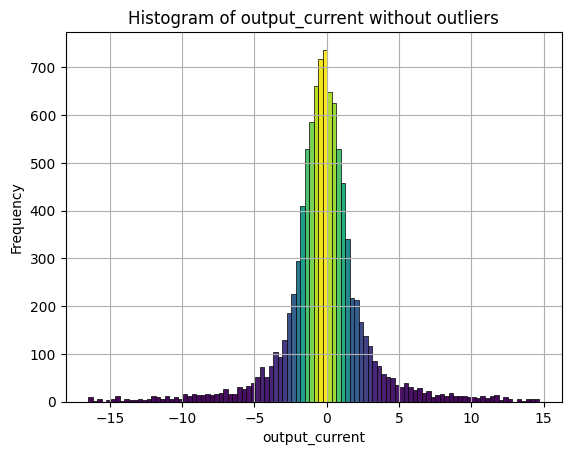

In [62]:
plot_histogram(df[(df["output_current"] >= q[4]) & (df["output_current"] <= q[5])]["output_current"], title="Histogram of output_current without outliers", xlabel="output_current", ylabel="Frequency", bins=100)

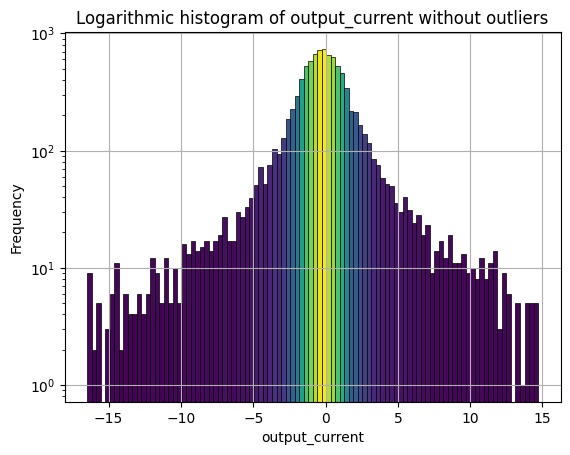

In [61]:
plot_histogram(df[(df["output_current"] >= q[4]) & (df["output_current"] <= q[5])]["output_current"], title="Logarithmic histogram of output_current without outliers", xlabel="output_current", ylabel="Frequency", bins=100, yscale="log")

The distribution without the outliers looks more similar to a bell curve.

# Distributions

The *impedance*, *impedance_fluctuation* and *output_current* variables could be normally distributed. We can check if this is indeed the case using a Kolmogorov-Smirnov test. For each test, the null hypothesis is that the variable is a normal distribution, and the alternative hypothesis, that it is not:

$$
H_0: X \in N(\mu, \sigma)
$$
$$
H_1: X \notin N(\mu, \sigma)
$$

where $X$ is the variable to analyze and $\mu$ and $\sigma$ are the mean and standard deviation of the normal distribution, respectively. For the test, they are approximated as the mean and standard deviation of the sample data (the best possible estimators by the maximum likelihood method).


In [33]:
def is_normally_distributed(data, alpha):
    mu,sigma = pd.Series(data).mean(), pd.Series(data).std()
    test_stat, p_value = kstest(data, np.random.normal(mu,sigma,10000))

    if p_value < alpha:
        print("The p-value is {}. We have statistical evidence in favour of the alternative hypothesis. Thus we have proved that the data does not come from a normal distribution.".format(p_value))
    else:
        print("The p-value is {}. We do not have statistical evidence in order to reject the alternative hypothesis. Thus we can assume that the data comes from a normal distribution.".format(p_value))

is_normally_distributed(df["impedance"], 0.05)

The p-value is 0.8104868709244586. We do not have statistical evidence in order to reject the alternative hypothesis. Thus we can assume that the data comes from a normal distribution.


In [34]:
is_normally_distributed(df["impedance_fluctuation"], 0.05)

The p-value is 0.020004818169404498. We have statistical evidence in favour of the alternative hypothesis. Thus we have proved that the data does not come from a normal distribution.


In [35]:
is_normally_distributed(df["output_current"], 0.05)

The p-value is 0.0. We have statistical evidence in favour of the alternative hypothesis. Thus we have proved that the data does not come from a normal distribution.


# Correlations

Let us now compute the Pearson correlation coefficient between the variables.

In [36]:
def correlation_heatmap(data):
    # Correlation matrix
    corr = data.corr()

    # Create a mask to show only the lower triangular matrix
    # We use k=1 to exclude the diagonal from the mask
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    # We use fmt to set the number format to 2 decimal places
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm")

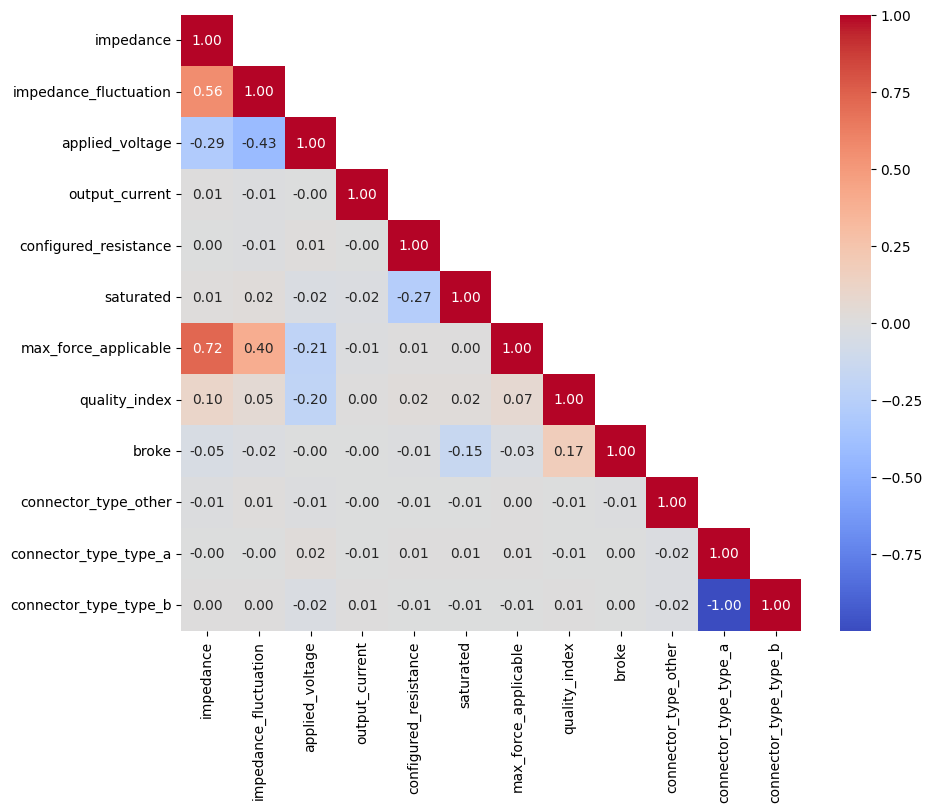

In [37]:
correlation_heatmap(df)

The only remarkable correlations are those of *connector_type_a* and *connector_type_b* (explained because of the fact that there so few connectors of the type 'other' that almost always, if a connector is not of type a, it is of type b, and viceversa).

We can obtain a scatter plot for every pair of variables similar to the one Weka creates. Note that the plot between an attribute and itself is different: it shows the distribution of the variable.

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


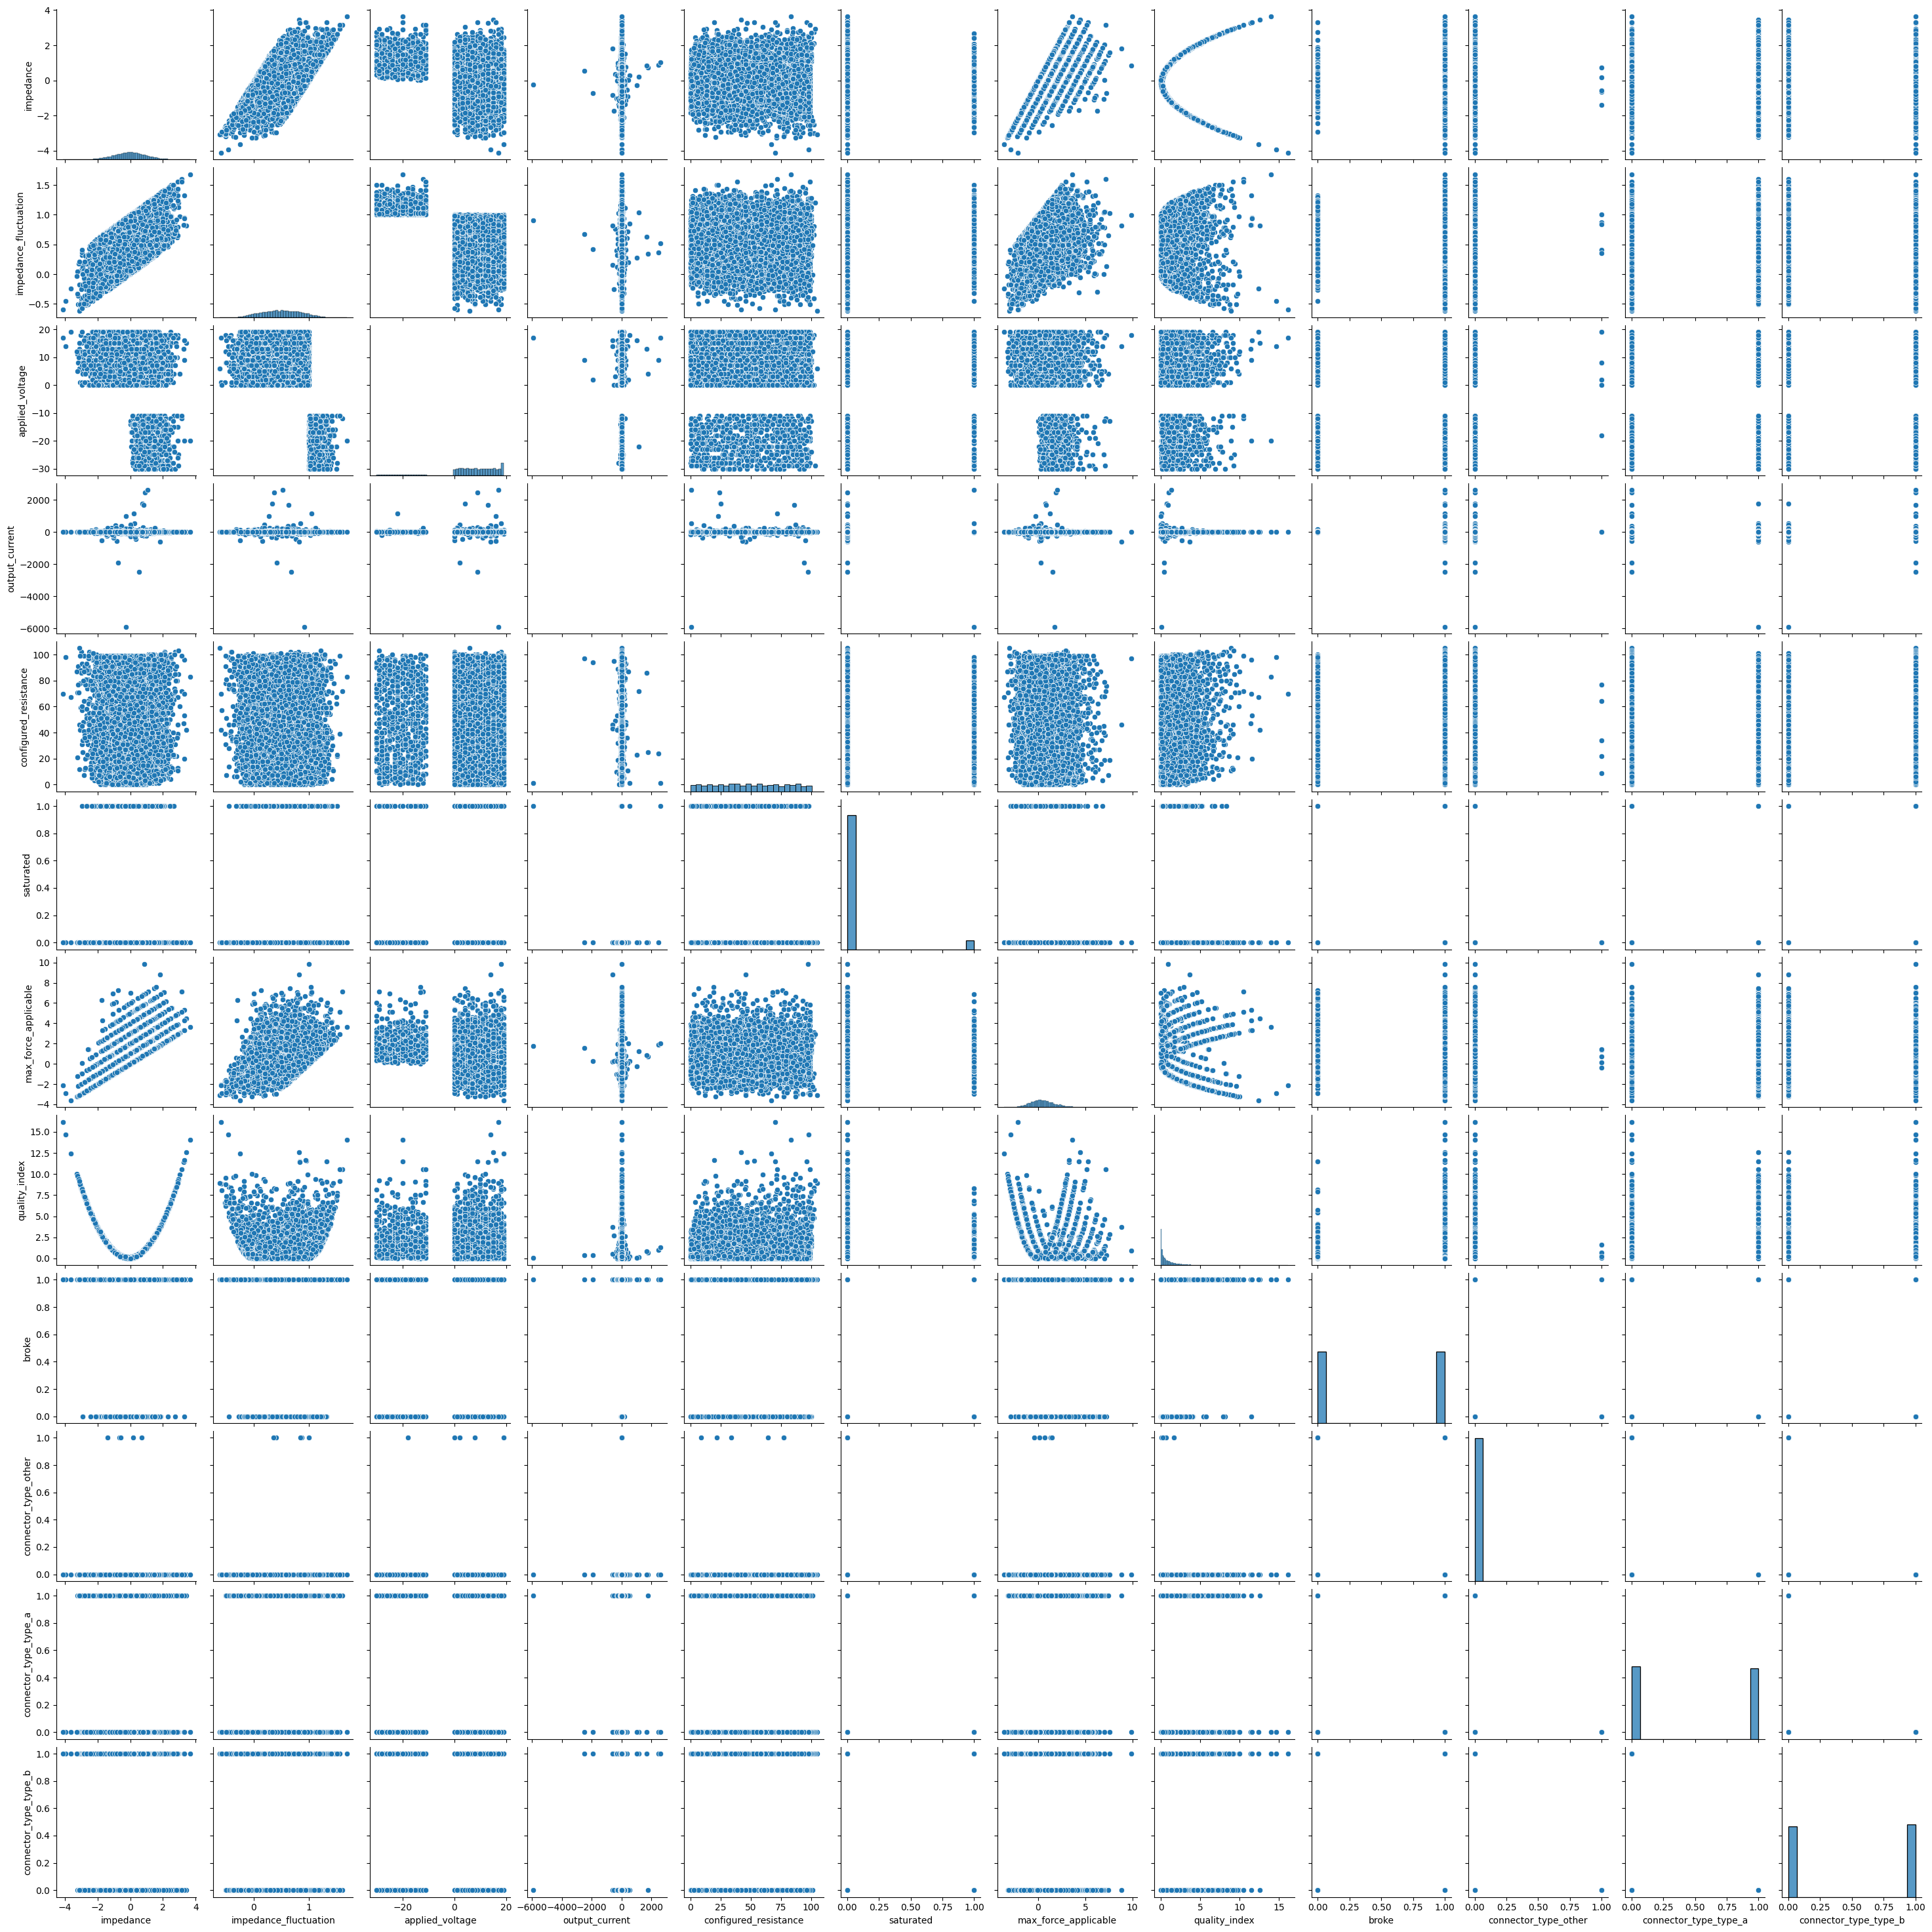

In [38]:
sns.pairplot(df, kind="scatter")
plt.show()

Let us examine with more detail some of the correlations. We will do so using boxplots.

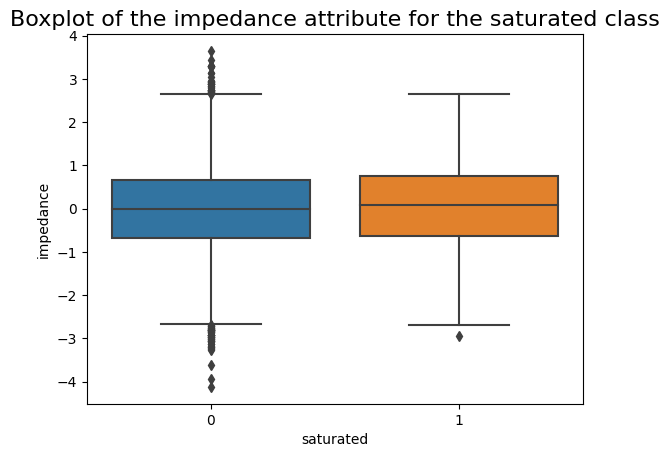

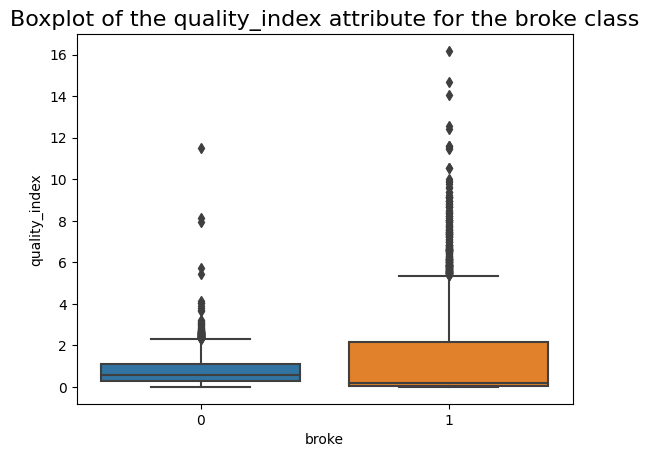

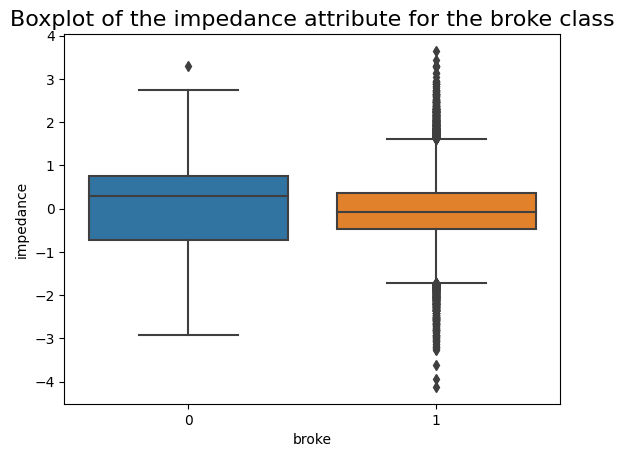

In [39]:
def boxplot(x, y, title):
    sns.boxplot(data=df, x=x, y=y)
    plt.title(title, fontsize=16)
    plt.show()

boxplot("saturated", "impedance", "Boxplot of the impedance attribute for the saturated class")
boxplot("broke", "quality_index", "Boxplot of the quality_index attribute for the broke class")
boxplot("broke", "impedance", "Boxplot of the impedance attribute for the broke class")

In general, a higher correlation causes the boxplots for different values of the categorical variable to be less similar, as they it has a higher dependence with the numerical variable. For example, *impedance* and *saturated* have a low correlation, and so the left and right boxplots are quite similar. In contrast, the ones between *broke* and *quality_index* have several differences: the right one has a higher interquartile range and assymetry. As in this case, there are many more outliers for the *impedance* instances that broke than for those that did not. Additionally, the former ones have a smaller interquartile range and asymmetry.

## Relationship between *quality_index* and *impedance*

It Weka, we have observed a relationship between *quality_index* and *impedance* that appears to be quadratic. We will now try to confirm this.

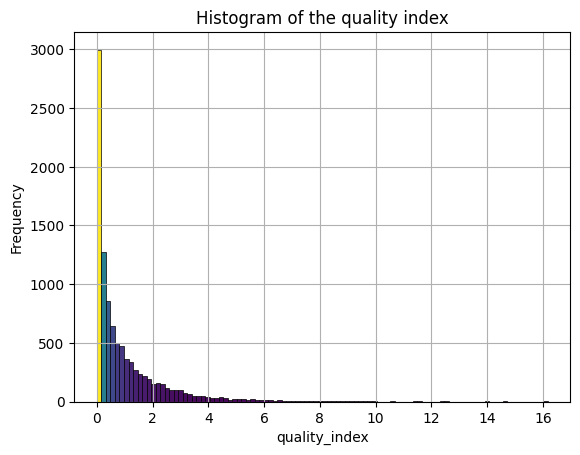

In [40]:
plot_histogram(df["quality_index"], title="Histogram of the quality index", xlabel="quality_index", ylabel="Frequency", bins=100)

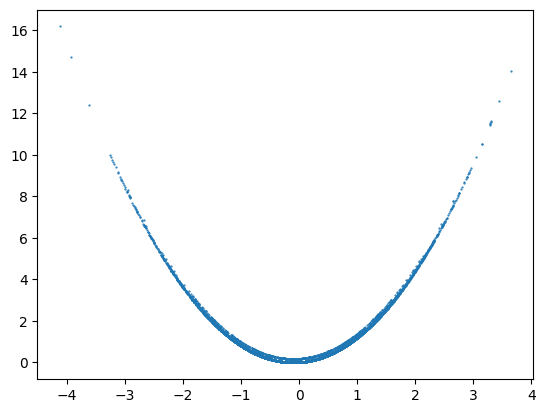

In [41]:
plt.scatter(df["impedance"], df["quality_index"], s=0.3)       # Scatter plot with s=0.3 to make the points smaller

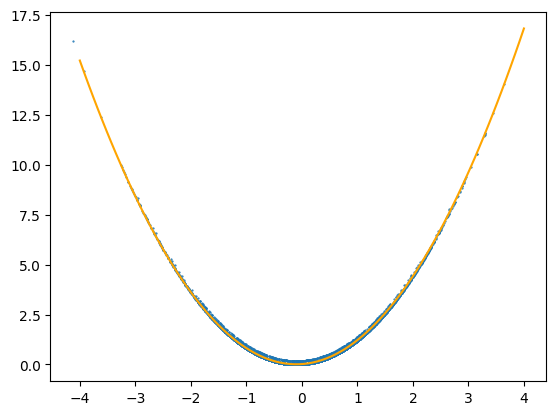

In [42]:
# Fit quadratic polynomial
model = np.poly1d(np.polyfit(df["impedance"], df["quality_index"], 2))

# Add the model to the scatter plot in orange
x = np.linspace(-4, 4, 100)
plt.scatter(df["impedance"], df["quality_index"], s=0.3)
plt.plot(x, model(x), c="orange")
plt.show()

In [43]:
model   # Coefficients of the quadratic polynomial

poly1d([0.9997862 , 0.20054353, 0.02060428])

The quadratic relationship is given by

$$
y = x^2 + 0.2*x + 0.02
$$

where $y = \text{quality\_index}$ and $x = \text{impedance}$.

In [44]:
r2_score(df['quality_index'], model(df['impedance']))

0.9991829564705259

The R-squared of the model indicates that 99.92% of the variation in *quality\_index* is explained by the impedance of the components. Since it is really high, we can assume that indeed, *quality_index* and *impedance* share a quadratic relationship.

# Attribute selection

Not all of the variables seem connected to the target. Eliminating those that just add noise to the analysis will let us give better conclusions.

To sistematically find the most important variables, we will use the function SelectKBest from the sklearn library. This function selects the k best features according to a statistical test. We will use an f-test to check if there is any significant difference between each variable and the target.

In [45]:
def select_f_test(num_features):
    features = df.drop(columns=["broke"])
    target = df["broke"]

    # Select the 7 best features using an F-test
    selector = SelectKBest(score_func=f_classif, k=num_features)           # k="all" to return all the features
    X_new = selector.fit_transform(features, target)

    selected_features_mask = selector.get_support()
    return selector, features.columns[selected_features_mask]       # return the selected features

In [46]:
def select_k_attrs(k):
    print("\nResults for k =", k)
    selector, selected_features = select_f_test(k)
    inds_present = selector.get_support(indices=True)
    for i, col in enumerate(selected_features):
        print(f"{col}: {selector.scores_[i]}")

In [47]:
df.columns

Index(['impedance', 'impedance_fluctuation', 'applied_voltage',
       'output_current', 'configured_resistance', 'saturated',
       'max_force_applicable', 'quality_index', 'broke',
       'connector_type_other', 'connector_type_type_a',
       'connector_type_type_b'],
      dtype='object')

In [48]:
select_k_attrs(10)      # Eliminate 1 feature


Results for k = 10
impedance: 20.932756404708414
impedance_fluctuation: 2.536776505554527
applied_voltage: 0.0017043946330171772
configured_resistance: 0.00018841368207805955
saturated: 1.465285360540563
max_force_applicable: 233.81097170943244
quality_index: 8.475246084421102
connector_type_other: 307.87101255396726
connector_type_type_a: 1.82559827054841
connector_type_type_b: 0.0012863530549175031


In [49]:
select_k_attrs(9)


Results for k = 9
impedance: 20.932756404708414
impedance_fluctuation: 2.536776505554527
applied_voltage: 0.0017043946330171772
configured_resistance: 0.00018841368207805955
saturated: 1.465285360540563
max_force_applicable: 233.81097170943244
quality_index: 8.475246084421102
connector_type_other: 307.87101255396726
connector_type_type_a: 1.82559827054841


In [50]:
select_k_attrs(8)


Results for k = 8
impedance: 20.932756404708414
impedance_fluctuation: 2.536776505554527
applied_voltage: 0.0017043946330171772
configured_resistance: 0.00018841368207805955
saturated: 1.465285360540563
max_force_applicable: 233.81097170943244
quality_index: 8.475246084421102
connector_type_other: 307.87101255396726


In [51]:
select_k_attrs(7)


Results for k = 7
impedance: 20.932756404708414
impedance_fluctuation: 2.536776505554527
configured_resistance: 0.0017043946330171772
saturated: 0.00018841368207805955
max_force_applicable: 1.465285360540563
quality_index: 233.81097170943244
connector_type_other: 8.475246084421102


The columns that are deleted for these four executions, in order, are *output\_current*, *connector_type_type_b*, *connector_type_type_a*, and *applied_voltage*. 

# Dependency of impedance with the maximum force applicable to the electric component

Let us start by creating a scatter plot and fitting a linear regression model to the data.

<Axes: xlabel='max_force_applicable', ylabel='impedance'>

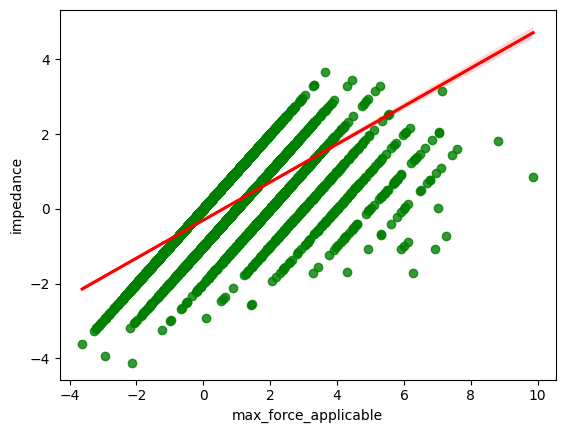

In [52]:
sns.regplot(x="max_force_applicable", y="impedance", data=df,
            scatter_kws={"color": "green"}, line_kws={"color": "red"})

The points appear to be divided in subgroups, which might imply that there is no linear relationship. We will do a linear regression test to confirm this.

In [53]:
linregress(df['max_force_applicable'], df['impedance'])

LinregressResult(slope=0.508840582386222, intercept=-0.3043056847194317, rvalue=0.7202490113907335, pvalue=0.0, stderr=0.004901688375568327, intercept_stderr=0.007454378788362696)

Using a simple linear regression model, we obtain that:
* The p-value (the significance of the linear relationship) is 0. This implies that there is enough evidence to reject the hypothesis that there is no correlation between the variables.
* The slope is positive, which indicates a direct relationship between the variables, i.e., the greater the maximum force applicable, the greater the impedance.
* The correlation coefficient (r-value) between the two variables is approximately 0.72, which is relatively high. This indicates that the strength of the linear relationship is quite strong.

Even then, other types of polynomials might be able to better fit the data. We will try with polynomials of degree 2, 3, 4 and 5, and examine their root mean squared error.

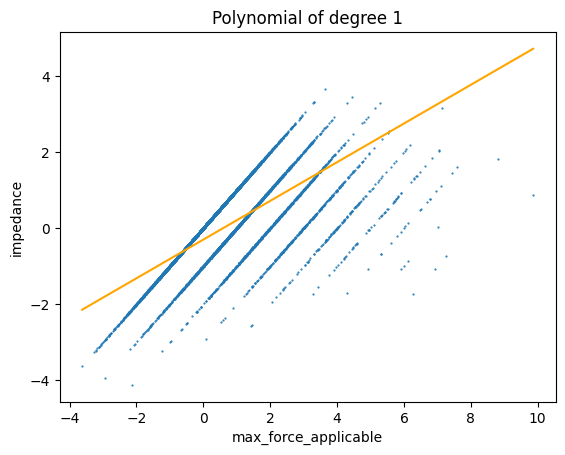

0.688835027885564


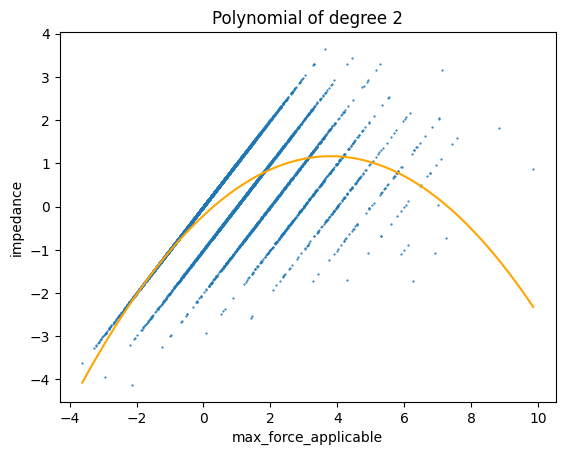

0.6073006129681865


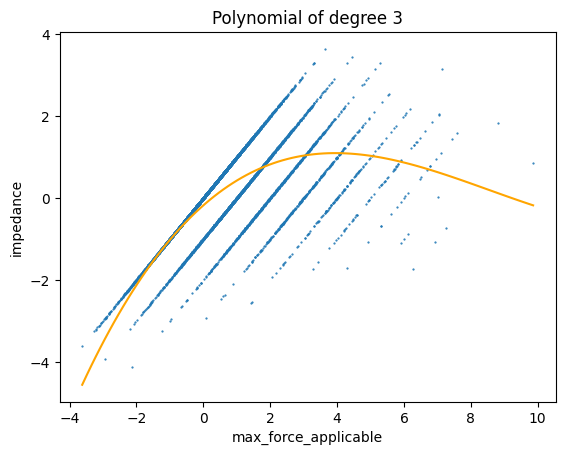

0.6052546328209474


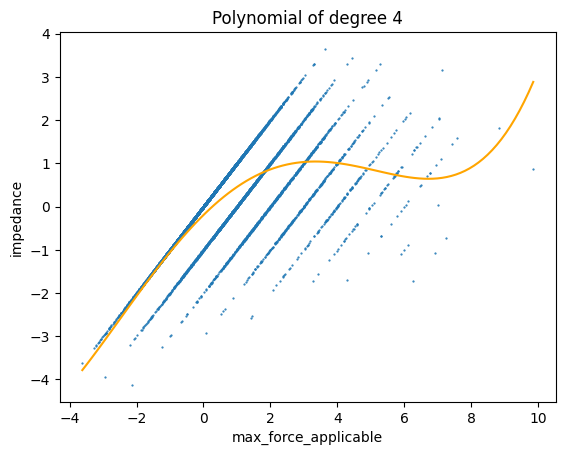

0.60283604894858


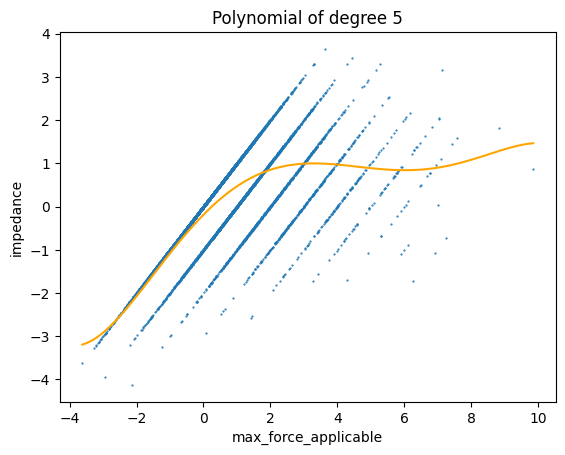

0.6021076069076492


In [54]:
def plot_polynomial(degree):    
    x_range = np.linspace(df["max_force_applicable"].min(), df["max_force_applicable"].max(), 100)
    coefs = np.polyfit(df["max_force_applicable"], df["impedance"], degree)
    polynomial = np.poly1d(coefs)
    
    plt.scatter(df["max_force_applicable"], df["impedance"], s=0.3)
    plt.plot(x_range, polynomial(x_range), c="orange")
    plt.xlabel("max_force_applicable")
    plt.ylabel("impedance")
    plt.title(f"Polynomial of degree {degree}")
    plt.show()

    rmse = np.sqrt(np.mean((df["impedance"] - polynomial(df["max_force_applicable"])) ** 2))
    print(rmse)

for degree in [1, 2, 3, 4, 5]:
    plot_polynomial(degree)

As seen in the plots, none of the polynomials are able to properly emulate the diagonal straight lines pattern. Among the ones tried, the polynomial of degree 4 obtained the lowest RMSE.

We will now try to isolate one of the lines. Each of them has approximately a slope of 1, so we can calculate the intercept with the x-axis by subtracting *max_force_applicable* from *impedance*:

$$
y = mx + b \implies b = y - mx
$$

$y =$ *impedance*, $x =$ *max_force_applicable*, $m = 1$. 

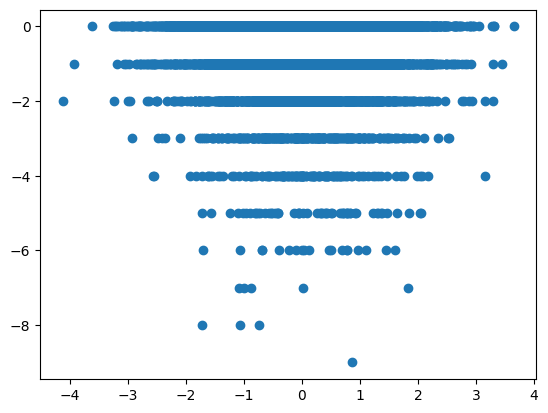

In [55]:
# Intercept with the x-axis assuming a slope of 1
df["intercept"] = df["impedance"] - df["max_force_applicable"]       #
plt.scatter(df["impedance"], df["intercept"])

In [56]:
df["intercept"].describe()

count    9999.000000
mean       -0.589559
std         0.975267
min        -9.000000
25%        -1.000000
50%         0.000000
75%         0.000000
max         0.000000
Name: intercept, dtype: float64

(array([1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.700e+01, 0.000e+00,
        0.000e+00, 5.500e+01, 0.000e+00, 0.000e+00, 1.210e+02, 0.000e+00,
        0.000e+00, 3.200e+01, 2.650e+02, 0.000e+00, 0.000e+00, 8.680e+02,
        0.000e+00, 0.000e+00, 2.327e+03, 0.000e+00, 0.000e+00, 6.303e+03]),
 array([-9. , -8.7, -8.4, -8.1, -7.8, -7.5, -7.2, -6.9, -6.6, -6.3, -6. ,
        -5.7, -5.4, -5.1, -4.8, -4.5, -4.2, -3.9, -3.6, -3.3, -3. , -2.7,
        -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ]),
 <BarContainer object of 30 artists>)

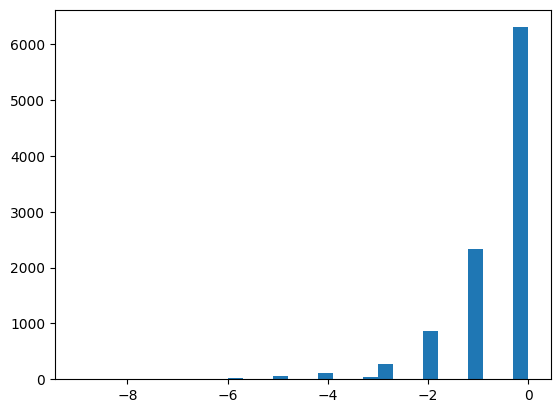

In [57]:
# Create a histogram of the intercept column
plt.hist(df["intercept"], bins=30)

In [58]:
df["intercept"] = round(df["intercept"])         # Eliminate the decimal part (noise)
df1 = df[df["intercept"] == -1]                  # Select one of the diagonal lines
df1.describe()                                   # Check the statistics

,impedance,impedance_fluctuation,applied_voltage,output_current,configured_resistance,saturated,max_force_applicable,quality_index,broke,intercept
count,2327.000000,2327.000000,2327.000000,2327.000000,2327.000000,2327.000000,2327.000000,2.327000e+03,2327.000000,2327.0
mean,0.009657,0.506296,6.909325,0.381165,50.309411,0.064031,1.009657,1.042081e+00,0.519983,-1.0
std,1.009849,0.354198,9.960236,103.351041,28.857309,0.244861,1.009849,1.469493e+00,0.499708,0.0
min,-3.932959,-0.592445,-30.000000,-2473.015178,0.000000,0.000000,-2.932959,2.930108e-08,0.000000,-1.0
25%,-0.641105,0.244093,3.000000,-1.470223,26.000000,0.000000,0.358895,1.081276e-01,0.000000,-1.0
50%,0.002115,0.512947,8.000000,-0.244706,50.000000,0.000000,1.002115,4.451538e-01,1.000000,-1.0
75%,0.677341,0.767297,14.000000,1.037695,76.000000,0.000000,1.677341,1.417121e+00,1.000000,-1.0
max,3.446100,1.505147,19.000000,2603.293146,102.000000,1.000000,4.446100,1.469157e+01,1.000000,-1.0


In [59]:
df3 = df[df["intercept"] == -3]                # Select one of the diagonal lines
df3.describe()                                 # Check the statistics

,impedance,impedance_fluctuation,applied_voltage,output_current,configured_resistance,saturated,max_force_applicable,quality_index,broke,intercept
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,2.970000e+02,297.000000,297.0
mean,0.018524,0.473368,7.626263,-1.033057,50.090909,0.043771,3.018524,8.790142e-01,0.505051,-3.0
std,0.927603,0.330874,9.117387,10.246832,29.355495,0.204931,0.927603,1.239918e+00,0.500818,0.0
min,-2.931544,-0.318737,-29.000000,-133.493497,0.000000,0.000000,0.068456,3.809186e-08,0.000000,-3.0
25%,-0.619085,0.235846,4.000000,-1.216549,24.000000,0.000000,2.380915,1.080307e-01,0.000000,-3.0
50%,0.001053,0.466056,9.000000,0.087283,50.000000,0.000000,3.001053,4.173754e-01,1.000000,-3.0
75%,0.649189,0.719008,14.000000,1.220583,75.000000,0.000000,3.649189,1.172341e+00,1.000000,-3.0
max,2.540791,1.388819,19.000000,28.453032,99.000000,1.000000,5.540791,8.017643e+00,1.000000,-3.0


In [60]:
df.describe()

,impedance,impedance_fluctuation,applied_voltage,output_current,configured_resistance,saturated,max_force_applicable,quality_index,broke,intercept
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9.999000e+03,9999.000000,9999.000000
mean,-0.008784,0.499905,7.065007,-0.138724,49.845585,0.062006,0.580775,1.004688e+00,0.502050,-0.589559
std,0.993014,0.352210,9.850136,83.630052,28.814403,0.241179,1.405583,1.416555e+00,0.500021,0.975267
min,-4.122472,-0.616887,-30.000000,-5897.951767,0.000000,0.000000,-3.621729,2.930108e-08,0.000000,-9.000000
25%,-0.675804,0.240536,3.000000,-1.433127,25.000000,0.000000,-0.359535,1.094331e-01,0.000000,-1.000000
50%,-0.005021,0.499282,8.000000,-0.201704,49.000000,0.000000,0.450385,4.599752e-01,1.000000,0.000000
75%,0.658960,0.762734,14.000000,1.048114,75.000000,0.000000,1.362258,1.323922e+00,1.000000,0.000000
max,3.649320,1.680663,19.000000,2603.293146,105.000000,1.000000,9.861365,1.618028e+01,1.000000,0.000000


There does not seem to be a relevant difference in the statistics of the other attributes when comparing individual lines between them or with the original datset.

# Note

The rest of the exercises were solved using only Weka. A complete analysis is available in the report.